This notebook is to demonstrate the application of AlphaBuilding ResCommunity by applying MPC on a single TCL

Replace the variable *PATH_TO_ROOT* to run the notebook 

In [1]:
import sys

PATH_TO_ROOT = 'C:/Users/walter/Desktop/git/AlphaBuilding-ResCommunity'
sys.path.insert(0,PATH_TO_ROOT)

In [2]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt

## Casadi is the package we use to implement MPC
from casadi import *

from gym_AlphaBuilding.envs import residential
from util.distribution import utility
from util.weather import noaa_weather

In [3]:
plt.rc('xtick', labelsize=14, color='grey')
plt.rc('ytick', labelsize=14, color='grey')
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=16)
plt.rc('savefig', dpi=330, bbox='tight')

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def generate_fig_name(fig_name):
    '''
    Generate the figure path and name
    To be used by plt.savefig function
    '''
    return '{}/docs/fig/{}'.format(PATH_TO_ROOT, fig_name)

## Prepare the environment

In [5]:
# Specify the environment parameters
city = 'Berkeley'
state = 'CA'

start_date = date(2020,8,1)
final_date = date(2020,8,2)

SAMPLE_SIZE = 1
STEP_SIZE = 15 # min
sim_horizon = (str(start_date), str(final_date))

In [6]:
# Download weather data from NOAA weather stations
# If you want to use your own weather data, skip this step
address = '{}, {}'.format(city, state)
station_ids, station_names = noaa_weather.find_closest_weather_station(noaa_weather.geocode_address(address))

# You might need to try a couple of weather stations, because some weather stations have large missing rate 
weather = noaa_weather.download_weather(station_ids[0], start_date.year)
weather = weather.tz_convert('America/Los_Angeles').tz_localize(None)  # remove tz-awareness

# truncate and resample the weather data to fit the simulation horizon and time step
weather_h = weather.resample('1H').mean()  # hourlu average to remove noise
weather_ts = weather_h.resample('{}min'.format(STEP_SIZE)).interpolate()

In [54]:
# To support the weather forecast function, 1 extra day of weather data needs to be input
weather_ts = weather_ts.truncate(before=start_date, after=final_date+timedelta(days=1))

In [8]:
weather_input = weather_ts
weather_input['Temperature'] = weather_input['Temperature']+10

In [9]:
# Retrieve the parameters
ttc = utility.get_ttc(state)
teq = utility.get_teq(state)
tsp, trange = utility.get_comfort_temp('cooling', 'ASHRAE PMV')

In [10]:
# Select the standard deviation of the modelling noise and measurement uncertainty

noise_sigma = 0.01
measurement_error_sigma = 0.2

In [11]:
np.random.seed(1)

env = residential.AlphaResEnv(sampleSize  = SAMPLE_SIZE, 
                           stepSize    = STEP_SIZE, 
                           simHorizon  = sim_horizon,
                           ambientWeather = weather_input, 
                           ttc = ttc, 
                           teq = teq, 
                           tsp = tsp, 
                           trange = trange,
                           hvacMode = 'cooling only',
                           noiseSigma = noise_sigma,
                           measurementErrorSigma = measurement_error_sigma)

C:\Users\walter\Anaconda3\envs\ecobee_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [12]:
pars = env.getParameters()
pars

,R,C,P_h,P_c,Q_h,Q_c,COP_h,COP_c,T_sp,T_range
0,3.478848,7.11812,3.950448,3.190601,7.756767,-9.357086,1.963516,2.932704,25.4,2.9


In [13]:
pars.loc[0, 'R']

3.4788481496100925

## Rule Based Control

In [14]:
# Implement a rule-based controller

class controller_RBC():
    def __init__(self, t_lower, t_upper):
        self.t_lower = t_lower
        self.t_upper = t_upper
    
    def action(self, t, a=0):
        if t < self.t_lower:
            action = 0
        elif t > self.t_upper:
            action = 2    # 2 for cooling
        else:
            action = a
        return action

In [15]:
t_lower = pars.loc[0, 'T_sp'] - pars.loc[0, 'T_range']/2
t_upper = pars.loc[0, 'T_sp'] + pars.loc[0, 'T_range']/2
    
controller_rbc = controller_RBC(t_lower, t_upper)

In [16]:
# Simulate conventional RBC

np.random.seed(1)

obs = env.reset()
act_previous = [0]*SAMPLE_SIZE

T_in_rbc = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
Action_rbc = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))

for time in T_in_rbc.index:
    t_in = obs[-SAMPLE_SIZE:]
    t_amb = [obs[0]]*SAMPLE_SIZE
    action = [0]*SAMPLE_SIZE
    for i in range(SAMPLE_SIZE):
        action[i] = controller_rbc.action(t_in[i], act_previous[i])
    obs,_,_,_ = env.step(np.array(action)*2)    # 2 for cooling
    T_in_rbc.loc[time] = t_in
    Action_rbc.loc[time] = action
    act_previous = action

Episode: 1
Total Energy Consumption (kWh)
0.0
Total Uncomfortable Degree Hours (K*h)
22.760876203786715


## MPC
### Read electricity price

In [67]:
e_price = pd.read_csv(f'{PATH_TO_ROOT}/data/e_price.csv', index_col=0)
e_price.index = pd.to_datetime(e_price.index)
e_price.head()

,e_price,d_price
date_time,,
2020-01-01 00:00:00,0.1115,21.08
2020-01-01 00:15:00,0.1115,21.08
2020-01-01 00:30:00,0.1115,21.08
2020-01-01 00:45:00,0.1115,21.08
2020-01-01 01:00:00,0.1115,21.08


<AxesSubplot:xlabel='date_time'>

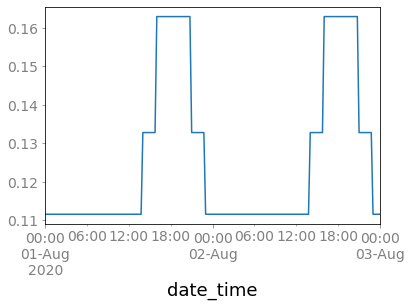

In [68]:
e_price = e_price.truncate(before = start_date, after = final_date+timedelta(days=1))
e_price['e_price'].plot()

### Run simulation

In [101]:
# Implement a rule-based controller

class controller_MPC():
    def __init__(self, R, C, T, N, Q_c):
        '''
        R: Thermal Resistance
        C: Thermal Capacity
        T: Time horizon, unit [h]
        N: Number of control steps
        Q_c: maximum cooling capacity, should be negative
        
        '''
        self.r = R
        self.c = C
        self.t = T
        self.n = N
        self.q_c = Q_c

        self.F_x = MX.sym('x')    # States

        self.F_to = MX.sym('to')  # Ambient temp
        self.F_u = MX.sym('u')    # Controls
        self.F_p = vertcat(self.F_to, self.F_u)

        self.F_ode = (self.F_to-self.F_x)/(self.r*self.c) + self.F_u/(self.r*self.c)

        self.F_dae = {'x':self.F_x, 'p':self.F_p, 'ode':self.F_ode}  # x-variable, change in each time step;
                                                                     # p-parameter, does not change in each time step
        self.F_opts = {'tf':self.t/self.n}

        self.F = integrator('F', 'cvodes', self.F_dae, self.F_opts)
    
    def action(self, t_current, t_ambient, t_eq, t_lower, t_upper, e_price):
        '''
        t_current: Indoor temperature of the current time step
        t_ambient: Ambient temperature of the coming hours, np array of size (N+1,)
        t_eq: Equivalent temperature of the coming hours, np array of size (N+1,)
        t_lower: Lower bound of comfort zone of the coming hours, np array of size (N+1,)
        t_upper: Upper bound of comfort zone of the coming hours, np array of size (N+1,)
        e_price: electricity price of the coming hours, np array of size (N+1,)
        '''
        opti = casadi.Opti()

        self.opti_X = opti.variable(1,self.n+1)  # Decision variables for states
        self.opti_U = opti.variable(1,self.n)    # Decision variables for controls
        self.opti_P = opti.parameter(4,self.n+1) # Parameter (not optimized over), [ambient temp., t_low, t_up, e_price]

        opti.minimize(-sum2(self.opti_U*self.opti_P[3,:-1]))

        for k in range(self.n):
            opti.subject_to(self.opti_X[0,k+1]==self.F(x0=self.opti_X[0,k], 
                                                       p =vertcat(self.opti_P[0,k], self.opti_U[0,k]))['xf'])
            opti.subject_to(self.opti_P[1,k+1]<=self.opti_X[0,k+1])
            opti.subject_to(self.opti_X[0,k+1]<=self.opti_P[2,k+1])

        opti.subject_to(self.opti_U<=0)
        opti.subject_to(self.opti_U>=self.q_c*self.r)
        opti.subject_to(self.opti_X[:,0]==t_current)
        
        opti.solver('ipopt')
        
        t_total = t_ambient+t_eq
        opti.set_value(self.opti_P, np.vstack((t_total, t_lower, t_upper, e_price)))
        
        sol=opti.solve()
        
        return sol.value(self.opti_U)

In [102]:
# Simulate MPC

np.random.seed(1)

obs = env.reset()

controller_mpc = controller_MPC(pars.loc[0, 'R'], pars.loc[0, 'C'], 24, 96, pars.loc[0, 'Q_c'])

T_in_mpc = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
Action_mpc = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))

In [103]:
obs

array([26.7       ,  7.        ,  0.        , 24.02942402])

In [104]:
t_current = obs[0];
input_data = env.weatherForecast()[['Temperature']]
t_eq = env.otherHGForecast().flatten()
t_eq = np.append(t_eq,t_eq[0])
input_data['t_eq'] = t_eq
input_data['t_lower'] = pars.loc[0, 'T_sp'] - pars.loc[0, 'T_range']/2
input_data['t_upper'] = pars.loc[0, 'T_sp'] + pars.loc[0, 'T_range']/2
input_data = input_data.resample('15T').interpolate(method='linear')

In [105]:
sol = controller_mpc.action(t_current, 
                            input_data['Temperature'].values,
                            input_data['t_eq'].values,
                            input_data['t_lower'].values,
                            input_data['t_upper'].values,
                            e_price.loc[input_data.index,'e_price'].values)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      289
Number of nonzeros in inequality constraint Jacobian.:      384
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      193
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       97
Total number of inequality constraints...............:      384
        inequality constraints with only lower bounds:      192
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      192

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

In [106]:
sol

array([-2.48518273e-07, -2.79388973e-07, -3.19085086e-07, -3.72019212e-07,
       -4.46133920e-07, -5.57314048e-07, -7.42623135e-07, -1.11324659e-06,
       -2.22507421e-06, -2.71444964e-01, -1.17891657e+00, -1.03829156e+00,
       -8.97666558e-01, -8.29210180e-01, -7.60753802e-01, -6.92297424e-01,
       -6.23841045e-01, -6.90053289e-01, -7.56265533e-01, -8.22477777e-01,
       -8.88690020e-01, -9.66815020e-01, -1.04494002e+00, -1.12306502e+00,
       -1.20119002e+00, -1.25744002e+00, -1.31369002e+00, -1.36994002e+00,
       -1.42619002e+00, -1.67694255e+00, -1.92769508e+00, -2.17844761e+00,
       -2.42920013e+00, -2.93917583e+00, -3.44915152e+00, -3.95912722e+00,
       -4.46910291e+00, -4.92282412e+00, -5.37654534e+00, -5.83026655e+00,
       -6.28398776e+00, -6.95259041e+00, -7.62119306e+00, -8.28979571e+00,
       -8.95839836e+00, -9.41911313e+00, -2.22964272e+01, -3.25518805e+01,
       -3.25518816e+01, -3.25518820e+01, -3.25518821e+01, -3.25518822e+01,
       -3.25518823e+01, -

In [23]:
for time in T_in_mpc.index:
    t_current = obs[0];
    t_forecast = env.weatherForecast()['Temperature']
    
    
    t_in = obs[-SAMPLE_SIZE:]
    t_amb = [obs[0]]*SAMPLE_SIZE
    action = [0]*SAMPLE_SIZE
    for i in range(SAMPLE_SIZE):
        action[i] = controller_rbc.action(t_in[i], act_previous[i])
    obs,_,_,_ = env.step(np.array(action)*2)    # 2 for cooling
    T_in_mpc.loc[time] = t_in
    Action_mpc.loc[time] = action
    act_previous = action

Episode: 2
Total Energy Consumption (kWh)
0.0
Total Uncomfortable Degree Hours (K*h)
22.760876203786715
